# Secret Manager Function

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

# Connecting to Database

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

# Q1

In [3]:
import warnings

warnings.simplefilter('ignore')

## Pull fips for state

In [4]:
import pandas as pd

sql_fips = """
SELECT fips, name
FROM name
WHERE name = 'New York';
"""

ny_fips = pd.read_sql(sql_fips, conn)
print(ny_fips)


  fips      name
0   36  New York


## Pull yearly population data

In [6]:
sql_population_fips = f"""
SELECT year, pop
FROM population
WHERE fips = '36'
ORDER BY year ASC;
"""

ny_df = pd.read_sql(sql_population_fips, conn)
ny_df.head()


,year,pop
0,2005,18655275
1,2006,19306183
2,2007,19297729
3,2008,19490297
4,2009,19541453


## Use Jupyter AI to calculate and plot growth rate

In [7]:
! pip install jupyter-ai-magics[all] -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.11.10 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.


In [8]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai_1')['api_key']

In [9]:
%load_ext jupyter_ai_magics

In [10]:
%%ai gpt4 -f code
Calculate the growth rate with the data provided in {ny_df}, use the ny_df directly, and visualize the result on a line chart

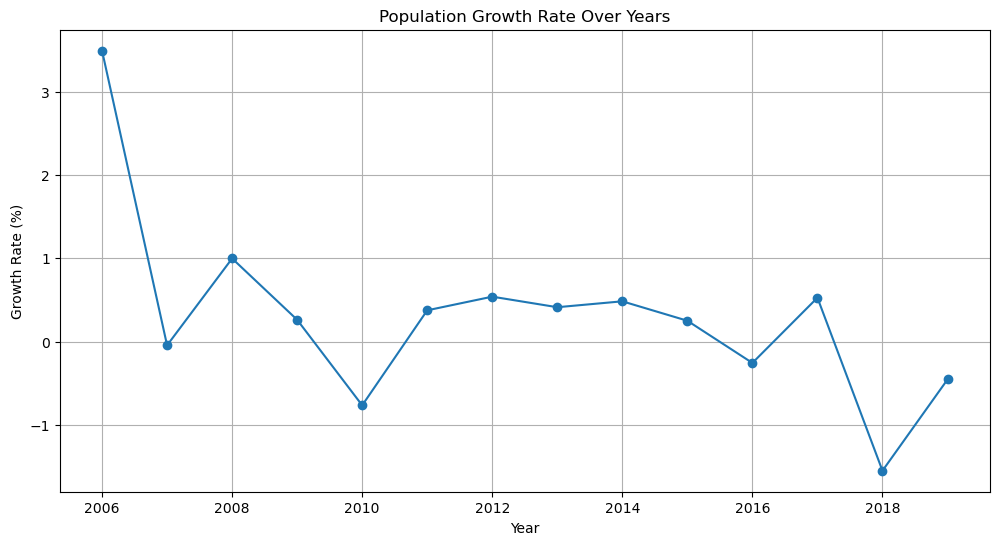

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
        'pop': [18655275, 19306183, 19297729, 19490297, 19541453, 19392283, 19465197, 19570261, 19651127, 19746227, 19795791,19745289,19849399, 19542209, 19453561]}

ny_df = pd.DataFrame(data)

# Calculate growth rate
ny_df['growth_rate'] = ny_df['pop'].pct_change() * 100

# Plot
plt.figure(figsize=(12, 6))
plt.plot(ny_df['year'], ny_df['growth_rate'], marker='o')
plt.title('Population Growth Rate Over Years')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

The graph shows the population growth rate by year starting from 2005. 2018 had the lowest growth rate in the graph, at roughly -1.5%. The highest growth rate was in 2006, at roughly 3.6%.

# Q2